# Predicting Loan Payback

![Kaggle Challenge](./assets/challenge.png)

This project focuses on predicting whether a borrower will repay their loan based on various features such as credit score, income, loan amount, and more. We will use machine learning techniques to build a predictive model. It is a **Kaggle Competition** part of the **Kaggle Playground Series (S5 E11)**


## 1. Import Libraries

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

import pandas as pd
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

from lightgbm import LGBMClassifier
import lightgbm as lgb
from scipy.stats import uniform, randint
import xgboost as xgb
import joblib

import warnings
warnings.filterwarnings('ignore')

## 2. Load Dataset

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

In [3]:
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
print(f"Train shape {train.shape}")
print(f"Test shape {test.shape}")

Train shape (593994, 12)
Test shape (254569, 11)


 **train.info()** is used to get a concise summary of the training data, including the data types of each column, the number of non-null values, and memory usage. This information is vital for identifying missing data, understanding column types (numerical vs. categorical), and estimating the memory footprint of the dataset.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 54.4+ MB



### About the Dataset

This dataset contains various features related to borrowers and the loans they received, culminating in a target variable indicating whether the loan was paid back.

#### 1. Borrower’s Demographics

* **gender** (`category`) – Borrower's gender (Male/Female).
* **marital\_status** (`category`) – Marital status (Single, Married, Divorced).
* **education\_level** (`category`) – Education level (High School, Bachelor, Master, PhD).

#### 2. Financial Information

* **annual\_income** (`float64`) – Borrower's yearly income.
* **employment\_status** (`category`) – Current employment type (Employed, Self-Employed, Unemployed).
* **debt\_to\_income\_ratio** (`float64`) – Ratio of borrower’s debt to their income. **Lower = better.**
* **credit\_score** (`int64`) – Credit bureau score (e.g., FICO). It shows how financially reliable you are (300–579: Poor, 580–669: Fair, 670–739: Good, 740+: Excellent)

#### 3. Loan Information

* **loan\_amount** (`float64`) – Amount of loan taken.
* **loan\_purpose** (`category`) – Loan purpose (Car, Education, Home, Medical, etc.).
* **interest\_rate** (`float64`) – Loan par annual interest rate (%).
* **grade\_subgrade** (`category`) – Risk category assigned to loan (A1, B2, C1,etc.).


#### 5. Target Variable

* **loan\_paid\_back** (`int64`) – Target variable:
    * **1** → Borrower paid loan in full.
    * **0** → Borrower defaulted (did not repay fully).

### Evaluation

The Kaggle competition's evaluation metric is the Area Under the ROC Curve **(AUC-ROC)**. This metric is highly suitable for **binary classification problems**, especially when dealing with imbalanced datasets, as it measures the model's ability to distinguish between the positive and negative classes across various probability thresholds. 

An AUC score of 1 represents a perfect classifier, while an AUC of 0.5 indicates a model performing no better than random chance. The accompanying ROC curve visualizes the trade-off between the true positive rate and the false positive rate at different classification thresholds, providing a comprehensive view of the model's discriminative power. Given the dataset's class imbalance (approximately 80% repayment vs. 20% default), AUC-ROC is a more **robust evaluation metric** than simple accuracy.

![AUC-ROC Curve](./assets/AUC-ROC.png)


## 3. Exploratory Data Analysis

### Check Null and Duplicate Values

Before proceeding with any analysis or modeling, it's essential to check for missing values and duplicate entries in the dataset. 

**isna().sum().sum()** are used to count the total number of null values in the training and testing sets, respectively. The results indicate that both datasets are clean and free from missing values, which simplifies the subsequent data preparation steps.


In [6]:
print("Number of null value in Train : ",train.isna().sum().sum())
print("Number of null value in Test : ",test.isna().sum().sum())

Number of null value in Train :  0
Number of null value in Test :  0


### Exploring target Variable

This imbalance is common in fraud or default prediction tasks and highlights the importance of choosing an appropriate evaluation metric. While accuracy might seem high by simply predicting the majority class, it wouldn't reflect the model's ability to identify defaults. Therefore, **ROC-AUC is the preferred metric**, as it assesses the model's capability to distinguish between the two classes regardless of the classification threshold.

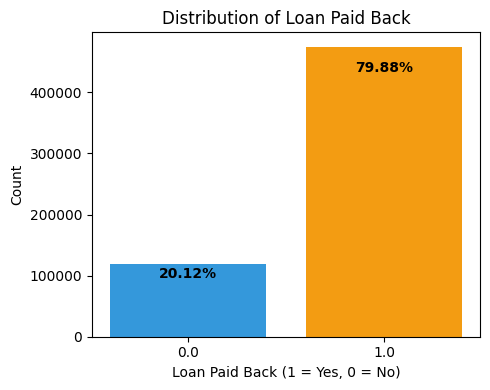

In [7]:
target_counts = train['loan_paid_back'].value_counts()
target_counts = train['loan_paid_back'].value_counts().sort_index()
target_percent = train['loan_paid_back'].value_counts(normalize=True) * 100


# 2. Plot
plt.figure(figsize=(5,4))
bars = plt.bar(target_counts.index.astype(str),
               target_counts.values,
               color=['#3498db', '#f39c12'])

# Add percentage labels on each bar
for bar in bars:
    height = bar.get_height()
    percent = (height / target_counts.sum()) * 100
    plt.text(bar.get_x() + bar.get_width()/2, height * 0.95,
             f'{percent:.2f}%', ha='center', va='top', fontsize=10, fontweight='bold')

plt.title('Distribution of Loan Paid Back')
plt.xlabel('Loan Paid Back (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The target variable shows a **moderate class imbalance**, with significantly fewer default cases. (80/20)

As a result, a naive model that always predicts repayment (1.0) would already achieve around 80% accuracy, yet its ROC-AUC would be poor since it fails to distinguish risk levels. 

For this reason, **ROC-AUC** is chosen as the **primary evaluation metric**, as it better captures the model’s ability to discriminate between repaid and defaulted loans.

Overall, approximately 80% of loans are repaid, while 20% result in default.

### Divide Numerical and Categorical Columns

To effectively preprocess and model the data, it's necessary to distinguish between numerical and categorical features. This separation is fundamental for applying appropriate preprocessing techniques, such as scaling for numerical features and encoding for categorical features, to prepare the data for machine learning algorithms.

In [10]:
target_col = 'loan_paid_back'

num_cols = train.select_dtypes(exclude= 'object').columns.drop('loan_paid_back')
cat_cols = train.select_dtypes(include= 'object').columns


print(f"\n Numerical features ({len(num_cols)}):")
for i, col in enumerate(num_cols, 1):
    print(f"   {i}. {col}")
print("="*50)
print(f"\n Categorical features ({len(cat_cols)}):")
for i, col in enumerate(cat_cols, 1):
    print(f"   {i}. {col}")

print(f"\n Total  features: {len(num_cols) + len(cat_cols)}")


 Numerical features (5):
   1. annual_income
   2. debt_to_income_ratio
   3. credit_score
   4. loan_amount
   5. interest_rate

 Categorical features (6):
   1. gender
   2. marital_status
   3. education_level
   4. employment_status
   5. loan_purpose
   6. grade_subgrade

 Total  features: 11


### I. Exploring Numerical Features

In [9]:
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990


In [10]:
num_cols

Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')

#### Correlation Matrix

We examine the linear relationships between numerical features and the target variable using the **Pearson Correlation Coefficient**.
*   **Feature-Target Correlation:** Identifies which features are strong linear predictors of loan repayment.
*   **Multicollinearity:** High correlation between two independent features (e.g., `loan_amount` and `monthly_payment`) implies redundant information, which can destabilize linear models like Logistic Regression.

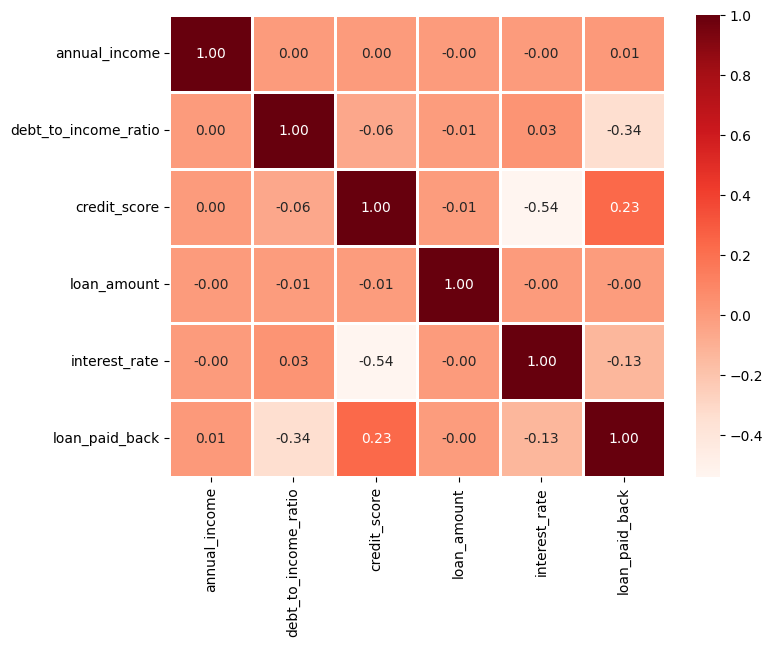

In [11]:
plt.figure(figsize=(8, 6))
cols_to_corr = num_cols.tolist() + [target_col]
correlation_matrix = train[cols_to_corr ].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            linewidths=1, cmap="Reds")
plt.show()

#### Distributions

Understanding the distribution of numerical features is crucial. We use histograms and Kernel Density Estimates (KDE) to inspect the data for:
*   **Skewness:** Are the data points clustered to the left or right? Highly skewed data (like income) often benefits from log-transformation.
*   **Normality:** Many models assume a normal (bell-shaped) distribution.
*   **Potential Outliers:** Bars isolated far from the main bulk of data suggest anomalies.

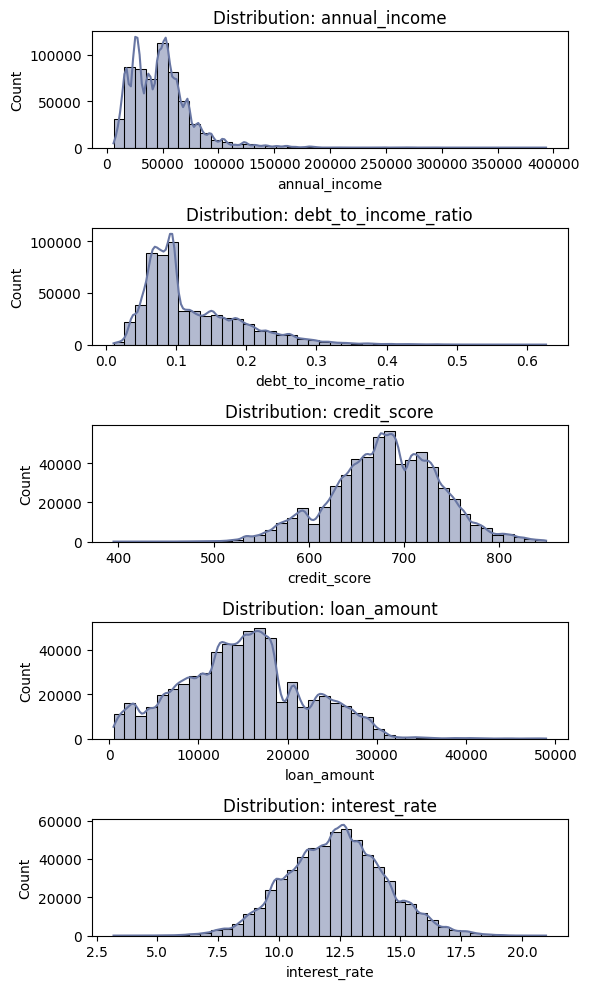

In [12]:
plt.figure(figsize=(6, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.histplot(train[col], kde=True, bins=40, color="#6876a3")
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()


#### Distribution Drift (Test vs Train)

It is vital to ensure that the Training data (historical loans) and Test data (future/unknown loans) come from the same distribution. If the statistical properties (Mean, Std) vary significantly between the two, our model might fail to generalize.
*   We compare descriptive statistics for both datasets to verify they align.
*   The KDE plots visualize the overlap between Train (Blue) and Test (Orange) distributions; a high overlap indicates good consistency.


annual_income Summary Statistics:


,Train,Test
Mean,48212.202976,48233.080193
Median,46557.680000,46528.980000
Std,26711.942078,26719.658580



debt_to_income_ratio Summary Statistics:


,Train,Test
Mean,0.120696,0.120583
Median,0.096000,0.096000
Std,0.068573,0.068582



credit_score Summary Statistics:


,Train,Test
Mean,680.916009,681.037691
Median,682.000000,683.000000
Std,55.424956,55.624118



loan_amount Summary Statistics:


,Train,Test
Mean,15020.297629,15016.753484
Median,15000.220000,15000.220000
Std,6926.530568,6922.165182



interest_rate Summary Statistics:


,Train,Test
Mean,12.356345,12.352323
Median,12.370000,12.370000
Std,2.008959,2.017602


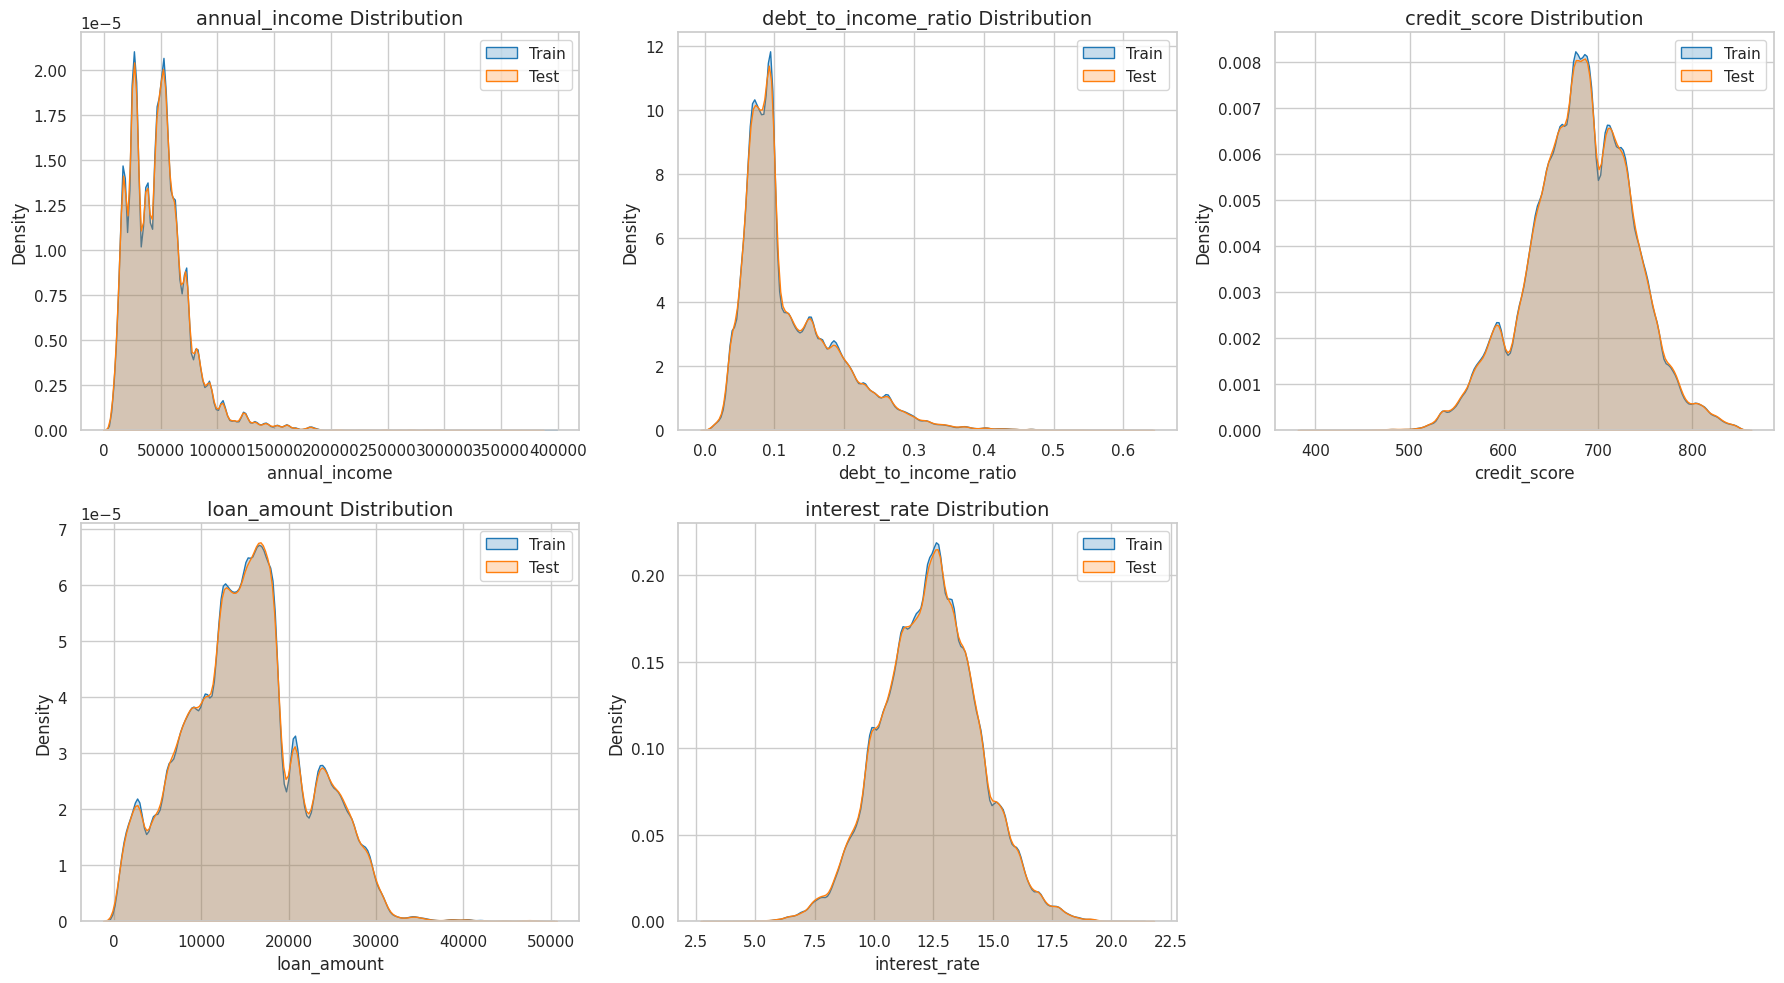

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("notebook")

palette = ['#1f77b4', '#ff7f0e']  

# Grid 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # pour itérer facilement

for i, col in enumerate(num_cols):  # num_cols contient les vraies colonnes
    # Vérifie que la colonne existe
    if col in train.columns and col in test.columns:
        # Statistiques
        print(f"\n{col} Summary Statistics:")
        display(pd.DataFrame({
            'Train': [train[col].mean(), train[col].median(), train[col].std()],
            'Test': [test[col].mean(), test[col].median(), test[col].std()]
        }, index=['Mean', 'Median', 'Std']))
        
        # Plot sur le subplot correspondant
        sns.kdeplot(data=train, x=col, fill=True, label='Train', color=palette[0], ax=axes[i])
        sns.kdeplot(data=test, x=col, fill=True, label='Test', color=palette[1], ax=axes[i])
        axes[i].set_title(f'{col} Distribution', fontsize=14)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
        axes[i].legend()
    else:
        print(f"Colonne {col} non trouvée dans train ou test.")

# Désactive le subplot vide
for j in range(len(num_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


#### Outliers

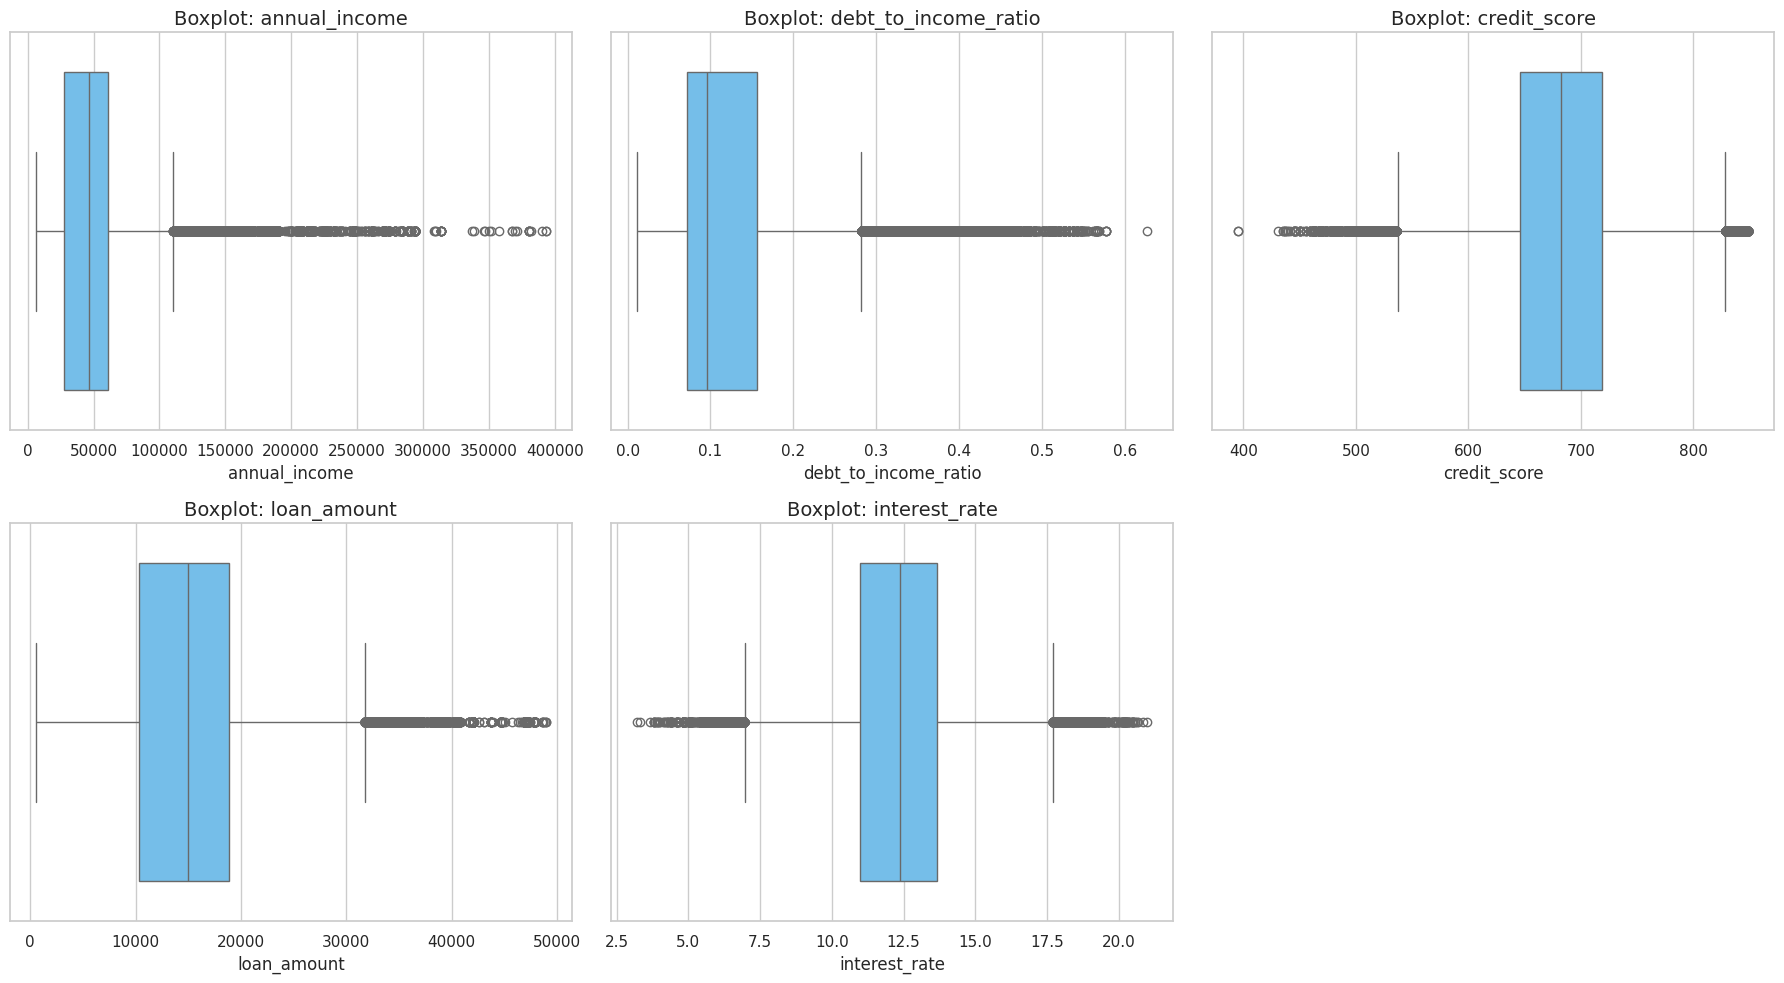

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook")

# Grid 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # pour itérer facilement

for i, col in enumerate(num_cols):
    # Vérifie que la colonne existe
    if col in train.columns:
        sns.boxplot(x=train[col], color="#62c3fc", ax=axes[i])
        axes[i].set_title(f'Boxplot: {col}', fontsize=14)
    else:
        print(f"Colonne {col} non trouvée dans train.")

# Désactive le subplot vide
for j in range(len(num_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

print("OUTLIER DETECTION (IQR METHOD)")

outlier_summary = []

n_rows = len(train)

for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (train[col] < lower_bound) | (train[col] > upper_bound)
    outlier_count = outlier_mask.sum()
    outlier_pct = (outlier_count / n_rows) * 100

    outlier_summary.append({
        'Feature': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outlier Count': outlier_count,
        'Outlier Percentage (%)': outlier_pct
    })

outlier_df = (
    pd.DataFrame(outlier_summary)
    .sort_values('Outlier Percentage (%)', ascending=False)
)

display(
    outlier_df.style
    .format({'Outlier Percentage (%)': '{:.2f}%'})
    .background_gradient(
        cmap='Reds',
        subset=['Outlier Count', 'Outlier Percentage (%)']
    )
)

print("\nOutlier Summary:")
print(f"- Features with outliers: {(outlier_df['Outlier Count'] > 0).sum()} / {len(outlier_df)}")
print(f"- Average outlier percentage: {outlier_df['Outlier Percentage (%)'].mean():.2f}%")


OUTLIER DETECTION (IQR METHOD)


,Feature,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Outlier Percentage (%)
1,debt_to_income_ratio,0.072000,0.156000,0.084000,-0.054000,0.282000,17556,2.96%
0,annual_income,27934.400000,60981.320000,33046.920000,-21635.980000,110551.700000,15917,2.68%
2,credit_score,646.000000,719.000000,73.000000,536.500000,828.500000,5901,0.99%
4,interest_rate,10.990000,13.680000,2.690000,6.955000,17.715000,5136,0.86%
3,loan_amount,10279.620000,18858.580000,8578.960000,-2588.820000,31727.020000,2902,0.49%



Outlier Summary:
- Features with outliers: 5 / 5
- Average outlier percentage: 1.60%


### II. Exploring Categorical Features 

#### Chi-square statistical test

To quantify the relationship between categorical features (e.g., `grade_subgrade`, `employment_status`) and the target (`loan_paid_back`), we use the **Chi-Square Test of Independence**.
*   **Null Hypothesis ($H_0$):** The feature and the target are independent (no relationship).
*   **P-Value:** A very small p-value (typically < 0.05) allows us to reject $H_0$, suggesting the feature is significant for prediction.
*   **Repayment Rate:** We also calculate the percentage of loans repaid for each category to identify high-risk groups (e.g., 'Unemployed').

In [17]:
import pandas as pd
from scipy.stats import chi2_contingency

target_col = 'loan_paid_back'

print("CHI-SQUARE TEST: CATEGORICAL FEATURES vs TARGET (TRAIN)")

chi2_summary = []

for col in cat_cols:
    # Contingency table
    contingency_table = pd.crosstab(train[col], train[target_col])

    # Chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    chi2_summary.append({
        'Feature': col,
        'Chi2 Statistic': chi2,
        'Degrees of Freedom': dof,
        'p-value': p_value
    })

chi2_df = pd.DataFrame(chi2_summary).sort_values('p-value')

display(
    chi2_df.style
    .format({'Chi2 Statistic': '{:.2f}', 'p-value': '{:.4e}'})
    .background_gradient(cmap='Greens_r', subset=['p-value'])
)


CHI-SQUARE TEST: CATEGORICAL FEATURES vs TARGET (TRAIN)


,Feature,Chi2 Statistic,Degrees of Freedom,p-value
3,employment_status,256259.86,4,0.0000e+00
5,grade_subgrade,30871.16,29,0.0000e+00
2,education_level,383.43,4,1.0552e-81
4,loan_purpose,391.33,7,1.7259e-80
0,gender,32.81,2,7.4954e-08
1,marital_status,4.12,3,2.4856e-01


for each categorical feature, we calculate the repayment rate (% of loan pay back) by category


=== GENDER ===

Summary:
         Count  Repayment_Rate
gender                        
Female  306175        0.801708
Male    284091        0.795752
Other     3728        0.795333

=== MARITAL_STATUS ===

Summary:
                 Count  Repayment_Rate
marital_status                        
Single          288843        0.798873
Married         277239        0.799144
Divorced         21312        0.796640
Widowed           6600        0.789848

=== EDUCATION_LEVEL ===

Summary:
                  Count  Repayment_Rate
education_level                        
Bachelor's       279606        0.788892
High School      183592        0.809698
Master's          93097        0.802346
Other             26677        0.802789
PhD               11022        0.830067

=== EMPLOYMENT_STATUS ===

Summary:
                    Count  Repayment_Rate
employment_status                        
Employed           450645        0.894145
Unemployed          62485        0.077619
Self-employed       52480      

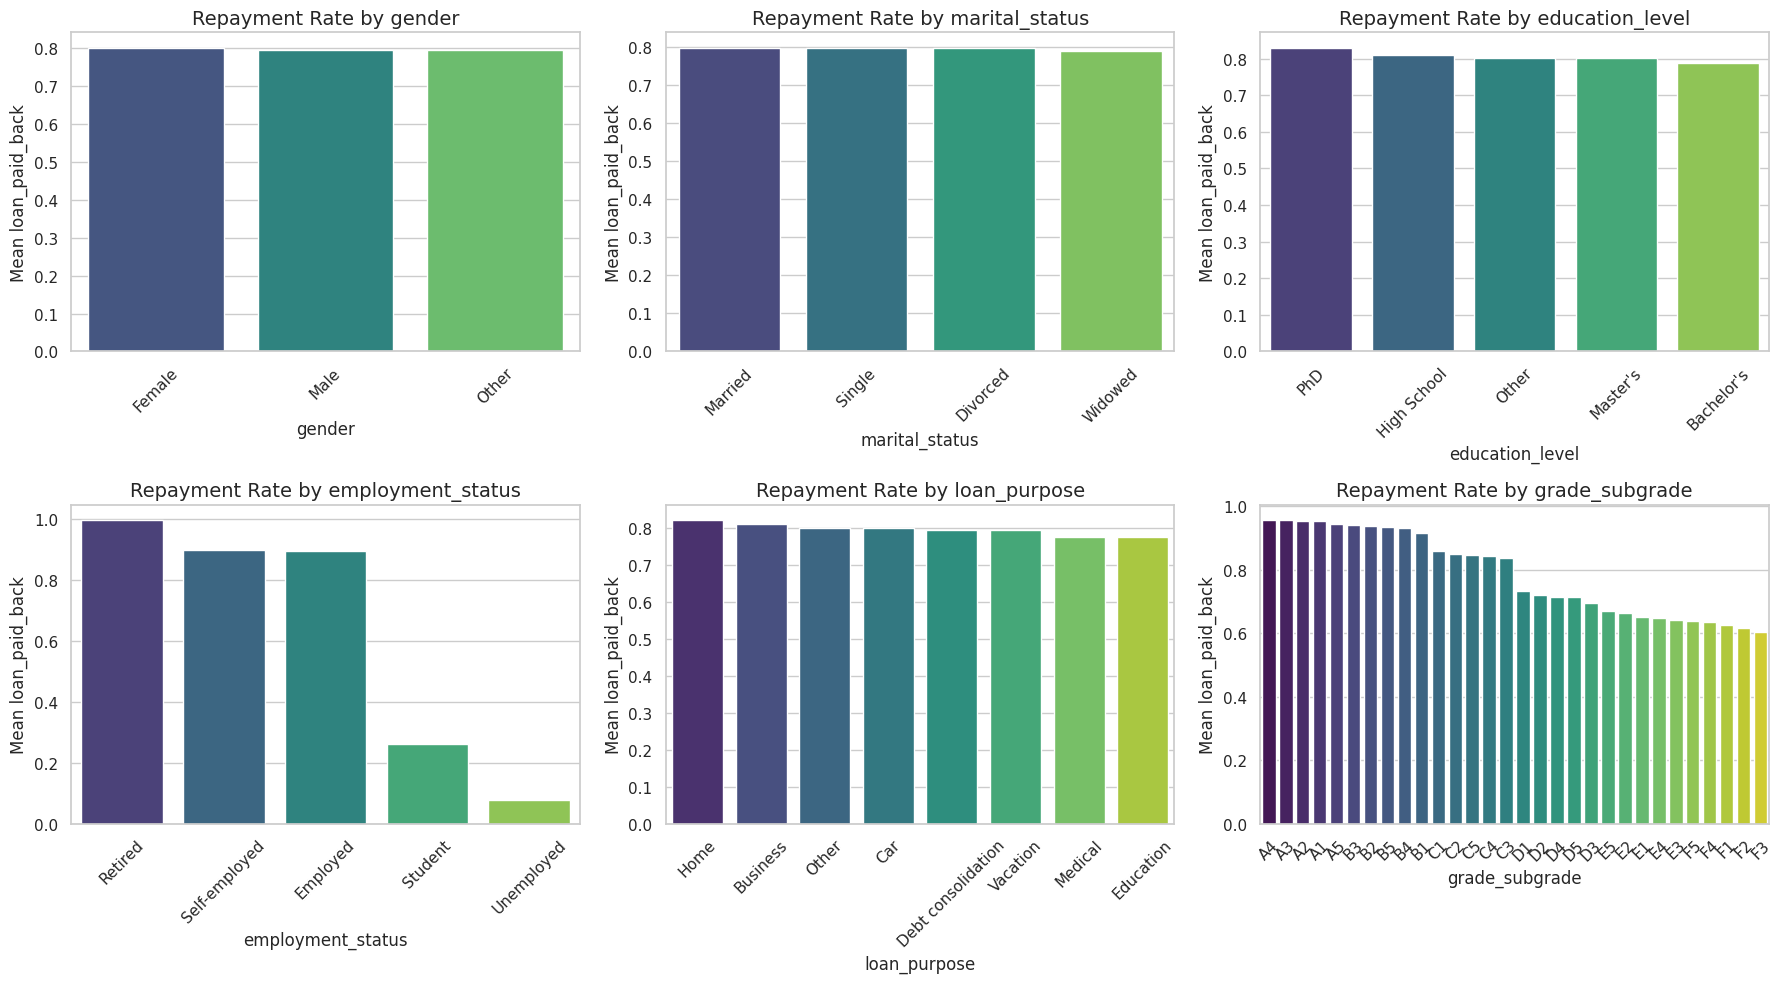

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("notebook")

# Grid 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # pour itérer facilement

for i, col in enumerate(cat_cols):
    if col in train.columns:
        print(f"\n=== {col.upper()} ===")
        
        # Frequency table
        freq = train[col].value_counts(dropna=False)
        
        # Repayment rate
        repayment_rate = train.groupby(col)['loan_paid_back'].mean().sort_values(ascending=False)
        
        # Combine
        summary = pd.concat([freq, repayment_rate], axis=1)
        summary.columns = ['Count', 'Repayment_Rate']
        print("\nSummary:")
        print(summary)
        
        # Bar plot sur le subplot correspondant
        sns.barplot(
            x=repayment_rate.index,
            y=repayment_rate.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f'Repayment Rate by {col}', fontsize=14)
        axes[i].set_ylabel('Mean loan_paid_back')
        axes[i].set_xlabel(col)
        axes[i].tick_params(axis='x', rotation=45)
    else:
        print(f"Colonne {col} non trouvée dans train.")

# Désactive les subplots vides
for j in range(len(cat_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



Feature: gender


,Train (%),Test (%)
gender,,
Female,51.55%,51.65%
Male,47.83%,47.71%
Other,0.63%,0.65%


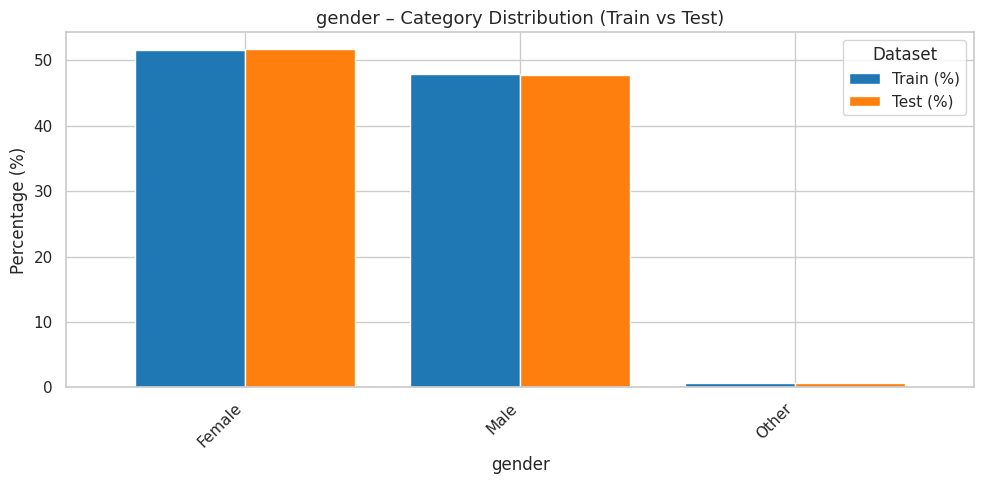


Feature: marital_status


,Train (%),Test (%)
marital_status,,
Single,48.63%,48.59%
Married,46.67%,46.75%
Divorced,3.59%,3.58%
Widowed,1.11%,1.08%


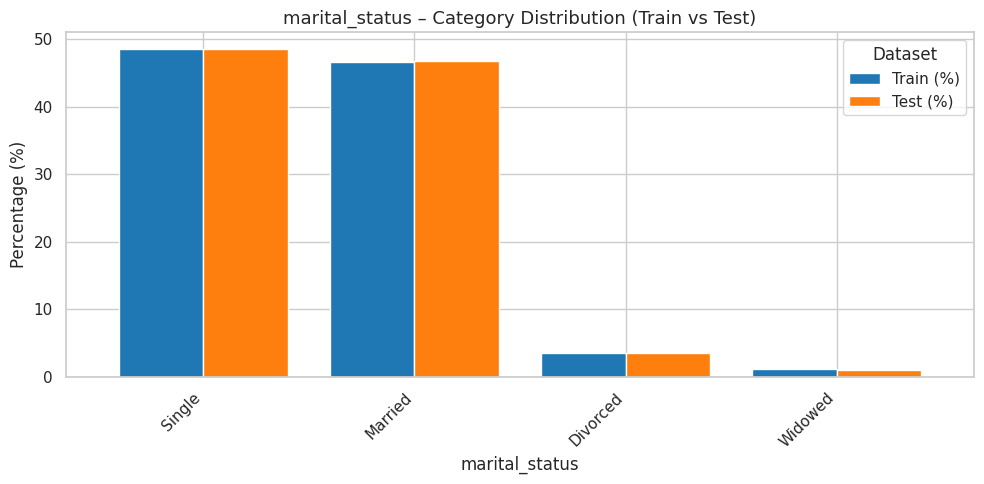


Feature: education_level


,Train (%),Test (%)
education_level,,
Bachelor's,47.07%,47.11%
High School,30.91%,30.91%
Master's,15.67%,15.64%
Other,4.49%,4.45%
PhD,1.86%,1.89%


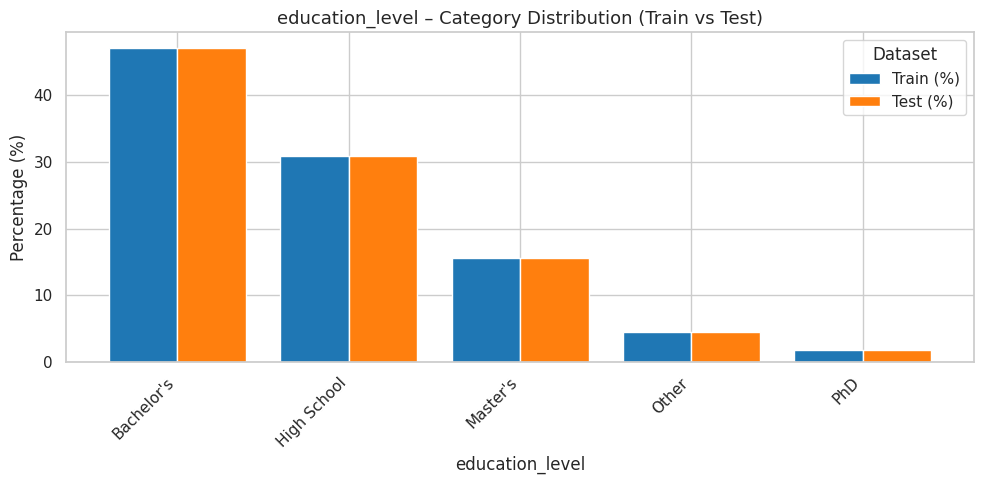


Feature: employment_status


,Train (%),Test (%)
employment_status,,
Employed,75.87%,75.90%
Unemployed,10.52%,10.49%
Self-employed,8.84%,8.86%
Retired,2.77%,2.77%
Student,2.01%,1.98%


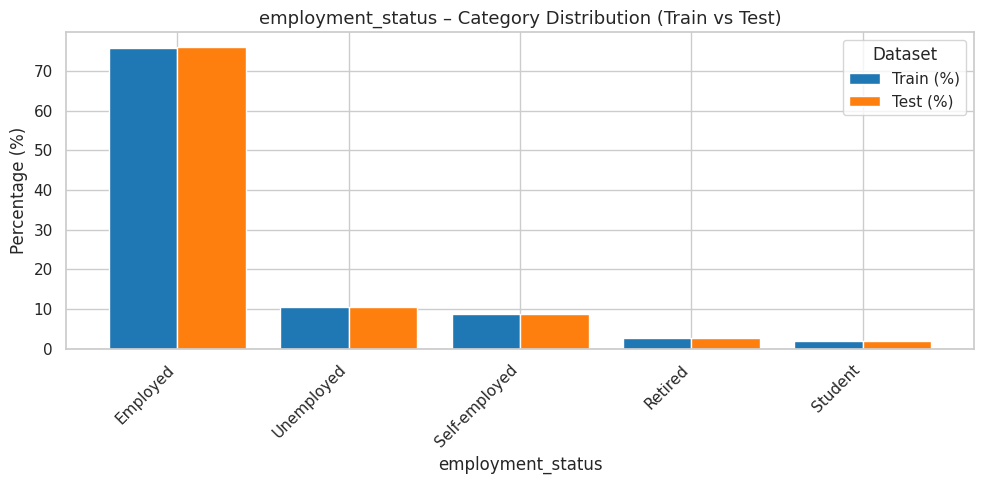


Feature: loan_purpose


,Train (%),Test (%)
loan_purpose,,
Debt consolidation,54.66%,54.59%
Other,10.75%,10.89%
Car,9.78%,9.78%
Home,7.43%,7.46%
Education,6.17%,6.17%
Business,5.94%,5.92%
Medical,3.84%,3.78%
Vacation,1.42%,1.42%


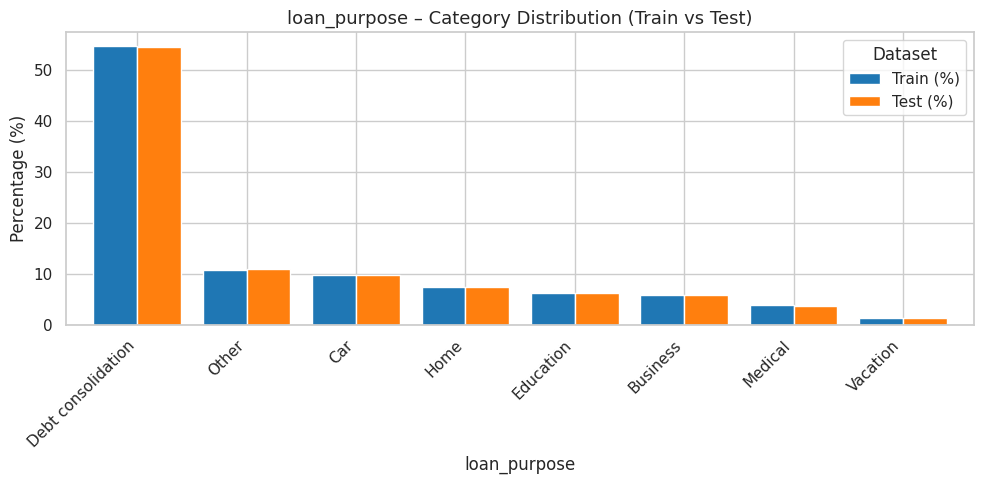


Feature: grade_subgrade


,Train (%),Test (%)
grade_subgrade,,
C3,9.88%,9.98%
C4,9.42%,9.31%
C2,9.17%,9.17%
C1,8.98%,8.96%
C5,8.98%,8.95%
D1,6.23%,6.18%
D3,6.18%,6.14%
D4,5.91%,5.89%
D2,5.80%,5.80%


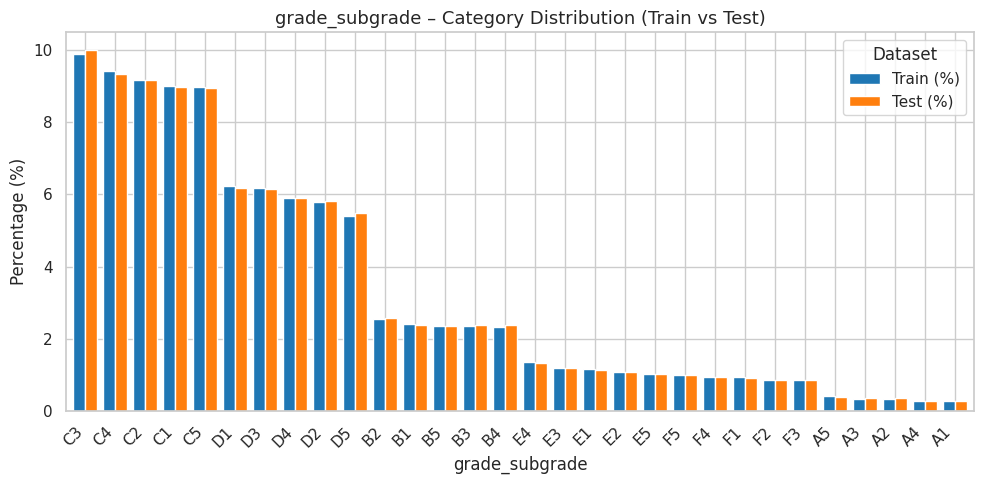

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


for col in cat_cols:
    print(f"\nFeature: {col}")

    # Percentage distribution
    train_dist = train[col].value_counts(normalize=True) * 100
    test_dist = test[col].value_counts(normalize=True) * 100

    dist_df = pd.concat([train_dist, test_dist], axis=1)
    dist_df.columns = ['Train (%)', 'Test (%)']
    dist_df = dist_df.fillna(0).sort_values('Train (%)', ascending=False)

    display(dist_df.style.format("{:.2f}%"))

    # Plot
    dist_df.plot(
        kind='bar',
        figsize=(10, 5),
        width=0.8
    )

    plt.title(f'{col} – Category Distribution (Train vs Test)', fontsize=13)
    plt.ylabel('Percentage (%)')
    plt.xlabel(col)
    plt.legend(title='Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## 4.Features Engineering

In [27]:
train_df = train.copy()
test_df = test.copy()

### Adding more advanced features

Raw data often contains hidden patterns that models might miss. In financial risk modeling, ratios are often more predictive than absolute numbers. We create several domain-specific features:
*   **Income Ratios:** Evaluating the loan amount relative to annual income.
*   **Debt Metrics:** Calculating total debt burden and available income after debt obligations.
*   **Risk Scoring:** A custom heuristic combining debt ratio, credit score, and interest rate to approximate borrower risk.
*   **Log Transformations:** Applied to `annual_income` and `loan_amount` to reduce skewness and limit the impact of extreme values.

In [28]:

def create_advanced_features(df):
    # Core affordability
    df['income_loan_ratio'] = df['annual_income'] / (df['loan_amount'] + 1)
    df['loan_to_income'] = df['loan_amount'] / (df['annual_income'] + 1)

    # Debt metrics
    df['total_debt'] = df['debt_to_income_ratio'] * df['annual_income']
    df['available_income'] = df['annual_income'] * (1 - df['debt_to_income_ratio'])
    df['debt_burden'] = df['debt_to_income_ratio'] * df['loan_amount']

    # Payment analysis
    df['monthly_payment'] = df['loan_amount'] * df['interest_rate'] / 1200
    df['payment_to_income'] = df['monthly_payment'] / (df['annual_income'] / 12 + 1)
    df['affordability'] = df['available_income'] / (df['loan_amount'] + 1)

    #Custom Risk scoring
    df['default_risk'] = (df['debt_to_income_ratio'] * 0.40 +
                          (850 - df['credit_score']) / 850 * 0.35 +
                          df['interest_rate'] / 100 * 0.25)

    # Credit analysis
    df['credit_utilization'] = df['credit_score'] * (1 - df['debt_to_income_ratio'])
    df['credit_interest_product'] = df['credit_score'] * df['interest_rate'] / 100

    # Log transformations
    for col in ['annual_income', 'loan_amount']:
        df[f'{col}_log'] = np.log1p(df[col])


    return df

train_df = create_advanced_features(train_df)
test_df = create_advanced_features(test_df)

### Deleting Outliers

Extreme values can skew the performance of machine learning models, particularly linear ones (like Logistic Regression) and distance-based algorithms. We use the **Interquartile Range (IQR)** method to detect and remove outliers. Data points falling below $Q1 - 1.5 \times IQR$ or above $Q3 + 1.5 \times IQR$ are considered outliers and removed from the training set to improve model stability.

In [ ]:

def remove_outliers_iqr(df, numerical_cols, factor=1.5):
    """
    Remove outliers from a DataFrame using the IQR method.

    Parameters:
    - df: pandas DataFrame
    - numerical_cols: list of numerical columns
    - factor: IQR multiplier (default = 1.5)

    Returns:
    - df_clean: DataFrame without outliers
    """
    df_clean = df.copy()

    for col in numerical_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        df_clean = df_clean[
            (df_clean[col] >= lower_bound) &
            (df_clean[col] <= upper_bound)
        ]

    return df_clean

train_df = remove_outliers_iqr(train, num_cols)
test_df = remove_outliers_iqr(test, num_cols)

### Droping unnecessary column

Based on the Chi-Square test performed in the EDA section, the `marital_status` feature showed a high p-value (or low statistic), indicating a weak relationship with the target variable `loan_paid_back`. We drop this column to reduce noise and dimensionality.

In [29]:
train_df.drop(["marital_status"], axis=1, inplace=True)
test_df.drop("marital_status", axis=1, inplace=True)
cat_cols = [col for col in cat_cols if col != 'marital_status']
num_cols = train_df.select_dtypes(exclude= 'object').columns.drop('loan_paid_back')


### Normalizing values

##### Numerical Columns

Machine learning algorithms are sensitive to the scale of input features. We apply **StandardScaler** to normalize numerical features, transforming them to have a mean of 0 and a standard deviation of 1. This ensures that features with larger magnitudes (like `annual_income`) do not dominate the objective function compared to smaller features (like `interest_rate`).

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.fit_transform(test_df[num_cols])


##### Categorical Columns

Machine learning models require numerical input. We use **One-Hot Encoding** (`get_dummies`) to convert categorical variables into binary columns. The parameter `drop_first=True` is used to avoid multicollinearity (the dummy variable trap), which is particularly important for linear models.


In [31]:
import pandas as pd

train_df = pd.get_dummies(
    train_df,
    columns=cat_cols,
    drop_first=True
)

bool_cols = train_df.select_dtypes(include='bool').columns
train_df[bool_cols] = train_df[bool_cols].astype(int)
train_df.head()


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back,income_loan_ratio,loan_to_income,total_debt,available_income,...,grade_subgrade_E1,grade_subgrade_E2,grade_subgrade_E3,grade_subgrade_E4,grade_subgrade_E5,grade_subgrade_F1,grade_subgrade_F2,grade_subgrade_F3,grade_subgrade_F4,grade_subgrade_F5
0,-0.705461,-0.535135,0.993849,-1.803484,0.653899,1.0,0.728275,-0.932934,-0.672835,-0.652208,...,0,0,0,0,0,0,0,0,0,0
1,-0.977248,0.660668,-0.810394,-1.505401,0.280571,0.0,-0.037493,-0.600551,-0.431438,-1.008517,...,0,0,0,0,0,0,0,0,0,0
2,0.050689,-0.345556,0.236067,0.286558,-1.292385,1.0,-0.251248,-0.230824,-0.203089,0.099618,...,0,0,0,0,0,0,0,0,0,0
3,-0.050687,-0.812211,-2.668764,-1.492497,1.863482,1.0,0.547424,-0.895135,-0.556678,0.059797,...,0,0,0,0,0,1,0,0,0,0
4,-0.850388,-0.987206,-0.287163,-0.409421,-1.068388,1.0,-0.343863,0.137445,-0.896688,-0.768229,...,0,0,0,0,0,0,0,0,0,0


In [32]:
test_df = pd.get_dummies(
    test_df,
    columns=cat_cols,
    drop_first=True
)

bool_cols_test_df = test_df.select_dtypes(include='bool').columns
test_df[bool_cols_test_df] = test_df[bool_cols_test_df].astype(int)
test_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,income_loan_ratio,loan_to_income,total_debt,available_income,...,grade_subgrade_E1,grade_subgrade_E2,grade_subgrade_E3,grade_subgrade_E4,grade_subgrade_E5,grade_subgrade_F1,grade_subgrade_F2,grade_subgrade_F3,grade_subgrade_F4,grade_subgrade_F5
0,593994,-0.728006,-1.043756,-0.989459,-0.513617,1.178469,-0.294842,-0.079089,-0.889513,-0.632558,...,0,0,0,0,0,0,0,0,0,0
1,593995,-0.060132,-0.402190,0.916193,0.068692,0.246668,-0.239111,-0.258865,-0.297456,-0.005741,...,0,0,0,0,0,0,0,0,0,0
2,593996,0.251568,3.593019,-1.259127,-1.620933,0.464749,1.042178,-0.976182,2.906102,-0.320999,...,0,0,0,0,0,0,0,0,0,0
3,593997,-0.845389,-0.154312,-0.180456,-1.219629,-1.379028,-0.139547,-0.465753,-0.604078,-0.823597,...,0,0,0,0,0,0,0,0,0,0
4,593998,-0.863165,-0.577162,0.125167,0.387183,0.221886,-0.416543,0.751851,-0.762345,-0.810691,...,0,0,0,0,0,0,0,0,0,0


## 5.Modeling

We will evaluate several algorithms ranging from simple linear models to complexe ensemble models.
*   **Metric:** ROC-AUC is used as the scoring metric due to the class imbalance.
*   **Validation:** We use **Stratified K-Fold Cross-Validation** to ensure each fold has the same proportion of target classes as the whole dataset.
*   **Tuning:** `GridSearchCV` is employed to find the optimal hyperparameters for each model.

### I. Simple Methods

#### Linear Regression

We start with Logistic Regression to establish a baseline. It is interpretable and efficient. 

In [41]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import joblib

# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Définir le modèle
model = LogisticRegression(max_iter=1000, solver='saga')

# Définir la grille d'hyperparamètres
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'class_weight': ['balanced']
}

# Stratified K-Fold pour GridSearch
cv_grid = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# GridSearchCV avec scoring ROC-AUC
grid = GridSearchCV(model, param_grid, cv=cv_grid, scoring='roc_auc', n_jobs=-1)
grid.fit(X, y)

# Meilleurs paramètres et score
print("Best params:", grid.best_params_)
print("Best ROC-AUC (CV mean):", round(grid.best_score_, 4))

# Sauvegarder le meilleur modèle
joblib.dump(grid.best_estimator_, "models/best_logreg_model.joblib")
print("Modèle sauvegardé sous 'models/best_logreg_model.joblib'")

Best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}
Best ROC-AUC (CV mean): 0.9112
Modèle sauvegardé sous 'models/best_logreg_model.joblib'


#### Naive Bayes

Naive Bayes algorithms are fast, probabilistic classifiers based on Bayes' Theorem, assuming independence between features.
*   **BernoulliNB:** Designed for binary/boolean features. It works well on our One-Hot Encoded variables.
*   **GaussianNB:** Assumes continuous features follow a normal distribution. It is applied here to capture patterns in our scaled numerical variables.

In [27]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import numpy as np

# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Définir le modèle
model = BernoulliNB()

# Définir le CV
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# Cross-validation sur ROC-AUC
scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

print("ROC-AUC scores per fold:", np.round(scores, 4))
print("Mean ROC-AUC:", np.round(scores.mean(), 4))


ROC-AUC scores per fold: [0.8661 0.8656 0.8653 0.8637 0.8652 0.8613 0.8643 0.8648]
Mean ROC-AUC: 0.8645


In [49]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import numpy as np

# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Définir le modèle
model = GaussianNB()

# Définir le CV
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# Cross-validation sur ROC-AUC
scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')


print("ROC-AUC scores per fold:", np.round(scores, 4))
print("Mean ROC-AUC:", np.round(scores.mean(), 4))

joblib.dump(model, "models/best_naive_bayes_model.joblib")
print("Modèle sauvegardé sous 'models/best_naive_bayes_model.joblib'")


ROC-AUC scores per fold: [0.8819 0.8769 0.878  0.8774 0.8793 0.8737 0.8792 0.8795]
Mean ROC-AUC: 0.8782
Modèle sauvegardé sous 'models/best_naive_bayes_model.joblib'


#### Decision Tree

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import joblib

# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Définir le modèle de base
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Grille d'hyperparamètres à tester
param_grid = {
    'max_depth': [4, 6, 8,],
    'min_samples_split': [10, 50],
    'min_samples_leaf': [10, 50],
}

# Stratified K-Fold pour GridSearch
cv_grid = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# GridSearchCV avec scoring ROC-AUC
grid = GridSearchCV(model, param_grid, cv=cv_grid, scoring='roc_auc', n_jobs=-1)
grid.fit(X, y)

# Meilleurs paramètres et score
print("Best params:", grid.best_params_)
print("Best ROC-AUC (CV mean):", round(grid.best_score_, 4))

# Sauvegarder le meilleur modèle
joblib.dump(grid.best_estimator_, "models/best_tree_model.joblib")
print("Modèle sauvegardé sous 'models/best_tree_model.joblib'")


Best params: {'max_depth': 8, 'min_samples_leaf': 50, 'min_samples_split': 10}
Best ROC-AUC (CV mean): 0.9115
Modèle sauvegardé sous 'best_tree_model.joblib'


### II. Advanced Methods

#### Bagging (Random Forrest)

Random Forest is an ensemble method that relies on **Bagging (Bootstrap Aggregating)**. It creates hundreds of Decision Trees on random subsets of the data and averages their predictions.
*   It reduces variance and is robust against overfitting compared to a single Decision Tree.
*   It handles non-linear relationships well and requires less preprocessing than linear models.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import joblib


# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Définir le modèle de base
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [6, 8],
    'min_samples_split': [10, 50],
    'min_samples_leaf': [50, 100]
}

# Stratified K-Fold pour GridSearch
cv_grid = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# GridSearchCV avec scoring ROC-AUC
grid = GridSearchCV(model, param_grid, cv=cv_grid, scoring='roc_auc', n_jobs=-1)
grid.fit(X, y)

# Meilleurs paramètres et score
print("Best params:", grid.best_params_)
print("Best ROC-AUC (CV mean):", round(grid.best_score_, 4))

# Sauvegarder le meilleur modèle
joblib.dump(grid.best_estimator_, "models/best_rf_model.joblib")
print("Modèle sauvegardé sous 'models/best_rf_model.joblib'")



Best params: {'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 10, 'n_estimators': 500}
Best ROC-AUC (CV mean): 0.9011
Modèle sauvegardé sous 'models/best_rf_model.joblib'


#### Boosting

##### 1. XGBoost

XGBoost is a powerful gradient boosting algorithm known for its speed and performance. It builds trees sequentially, with each new tree correcting errors made by previous ones. We tune `n_estimators` (number of trees), `max_depth` (tree complexity), and `learning_rate` to prevent overfitting while maximizing predictive power.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import numpy as np
import joblib
import pandas as pd

# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Modèle XGBoost de base
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Grille d'hyperparamètres (raisonnable pour commencer)
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
}

# Cross-validation
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# GridSearch
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

# Résultats
print("Best params:", grid.best_params_)
print("Best ROC-AUC (CV mean):", round(grid.best_score_, 4))

# Sauvegarde du meilleur modèle
joblib.dump(grid.best_estimator_, "models/best_xgboost_model.joblib")
print("Modèle sauvegardé sous 'models/best_xgboost_model.joblib'")


Best params: {'max_depth': 8, 'n_estimators': 1000, 'learning_rate': 0.05}
Best ROC-AUC (CV mean): 0.9195
Modèle sauvegardé sous 'models/best_xgboost_model.joblib'


##### 2. LGBM

LightGBM is a gradient boosting framework developed by Microsoft that uses tree-based learning algorithms. It is designed for speed and efficiency:
*   **Leaf-wise Growth:** Unlike other algorithms that grow trees level-wise, LightGBM grows trees leaf-wise (choosing the leaf with max delta loss), which can lower loss but may cause overfitting on small datasets.
*   It handles large datasets efficiently and often achieves higher accuracy than Random Forest.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import joblib

# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Définir le modèle de base
model = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    max_depth=6,
    eval_metric='auc',
    use_label_encoder=False,
    verbose=-1
)

# Grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.1]
}

# Stratified K-Fold pour GridSearch
cv_grid = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# GridSearchCV avec scoring ROC-AUC
grid = GridSearchCV(model, param_grid, cv=cv_grid, scoring='roc_auc', n_jobs=-1)
grid.fit(X, y)

# Meilleurs paramètres et score
print("Best params:", grid.best_params_)
print("Best ROC-AUC (CV mean):", round(grid.best_score_, 4))

# Sauvegarder le meilleur modèle
joblib.dump(grid.best_estimator_, "models/best_lgbm_model.joblib")
print("Modèle sauvegardé sous 'models/best_lgbm_model.joblib'")


##### 3. CatBoost

CatBoost (Categorical Boosting) is another gradient boosting algorithm, developed by Yandex. It is particularly known for:
*   **Symmetric Trees:** It builds balanced trees, which helps in execution speed and preventing overfitting.
*   **Robustness:** It often provides great results with default parameters and handles categorical features internally (though we pre-encoded them here).

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier
import numpy as np

# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Définir le modèle
model = CatBoostClassifier(
    max_depth=8,             
    eval_metric='AUC',       
    random_state=42,
    verbose=0
)

# Grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.1]
}

# Stratified K-Fold pour GridSearch
cv_grid = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# GridSearchCV avec scoring ROC-AUC
grid = GridSearchCV(model, param_grid, cv=cv_grid, scoring='roc_auc', n_jobs=-1)
grid.fit(X, y)

# Meilleurs paramètres et score
print("Best params:", grid.best_params_)
print("Best ROC-AUC (CV mean):", round(grid.best_score_, 4))

# Sauvegarder le meilleur modèle
joblib.dump(grid.best_estimator_, "models/best_lgbm_model.joblib")
print("Modèle sauvegardé sous 'models/best_lgbm_model.joblib'")


Best params: {'max_depth': 8, 'n_estimators': 1000, 'learning_rate': 0.1}
Best ROC-AUC (CV mean): 0.9213
Modèle sauvegardé sous 'models/best_catboost_model.joblib'


#### Stacking Classifier
To maximize performance, we employ a **Stacking Classifier**. This technique combines the predictions of several strong base learners (LightGBM, XGBoost, and CatBoost) and uses a **"meta-learner"** (Logistic Regression) to learn how to best combine their outputs. Stacking often yields better results than any single model by leveraging the diverse strengths of different algorithms.

In [48]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np

# Séparer X et y
target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Définir les modèles de base
estimators = [
    ('lgbm', LGBMClassifier(
        n_estimators=1000,        # nombre d’arbres
        max_depth=6,             # profondeur maximale
        learning_rate=0.1,      # taux d'apprentissage
        eval_metric='auc',       # métrique pour XGBoost
        use_label_encoder=False, # éviter warning
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )),
    ('xgb', XGBClassifier(
        n_estimators=1000,        # nombre d’arbres
        max_depth=8,             # profondeur maximale
        learning_rate=0.05,      # taux d'apprentissage
        eval_metric='auc',       # métrique pour XGBoost
        use_label_encoder=False, # éviter warning
        random_state=42,
        n_jobs=-1,
        verbose=0
    )),
    ('cat', CatBoostClassifier(
        n_estimators=1000,        # nombre d’arbres
        max_depth=8,             # profondeur maximale
        learning_rate=0.1,      # taux d'apprentissage
        eval_metric='AUC',       # métrique pour CatBoost
        random_state=42,
        verbose=0
    ))
]

# Méta-modèle
meta_model = LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs', class_weight='balanced')

# Stacking Classifier
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,                # pour créer les features pour le méta-modèle
    n_jobs=-1,
    passthrough=True     # les features originales passent aussi au méta-modèle
)

# Définir le CV
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# Cross-validation sur ROC-AUC
scores = cross_val_score(stack_model, X, y, cv=cv, scoring='roc_auc')

print("Stacking Classifier Results:")
print("ROC-AUC scores per fold:", np.round(scores, 4))
print("Mean ROC-AUC:", np.round(scores.mean(), 4))


[17:15:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

[17:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

[17:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

[17:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

[17:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

[17:20:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

[17:20:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

[17:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

[17:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "

Stacking Classifier Results:
ROC-AUC scores per fold: [0.9213 0.9196 0.9188 0.9174 0.9197 0.9171 0.9202 0.9185]
Mean ROC-AUC: 0.9191


## 6. Model Selection & Submission 

We select the best performing model (in this case, LightGBM loaded from the previous steps) to generate probabilities for the test set. Instead of predicting binary classes (0 or 1), we predict the **probability** of repayment (`predict_proba`), which is required for the ROC-AUC evaluation metric.

In [ ]:
model = joblib.load("models/best_lgbm_model.joblib")

X_test = test_df.drop(columns=["id"], errors="ignore")

test_predictions_proba = model.predict_proba(X_test)[:, 1]

submission_df = pd.DataFrame({
    "id": test_df["id"].values,
    "loan_paid_back": test_predictions_proba
})

submission_df.to_csv("data/sample_submission.csv", index=False)
print(submission_df.head())


       id  loan_paid_back
0  593994        0.916497
1  593995        0.983079
2  593996        0.543883
3  593997        0.922170
4  593998        0.960129
